In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls /content/drive/MyDrive/asr_lab
!ls /content/drive/MyDrive/asr_lab/wavs
!ls /content/drive/MyDrive/asr_lab/refs

domains  refs  results	wavs
audio10.wav  audio2.wav  audio4.wav  audio6.wav  audio8.wav
audio1.wav   audio3.wav  audio5.wav  audio7.wav  audio9.wav
audio10.txt  audio2.txt  audio4.txt  audio6.txt  audio8.txt
audio1.txt   audio3.txt  audio5.txt  audio7.txt  audio9.txt


In [ ]:
import os


DATA_DIR = "/content/drive/MyDrive/asr_lab"
AUDIO_DIR = f"{DATA_DIR}/wavs"
REF_DIR = f"{DATA_DIR}/refs"
OUT_DIR = f"{DATA_DIR}/results"

# Создаём папки, если их нет
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(f"{OUT_DIR}/hypotheses", exist_ok=True)
os.makedirs(f"{OUT_DIR}/metadata", exist_ok=True)

print("✅ Папки созданы:")
!ls "$DATA_DIR"

✅ Папки созданы:
refs  results  wavs


In [4]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 36.5 MB/s eta 0:00:00


In [3]:
!pip install faster-whisper

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.8/38.8 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 91.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.4 MB/s eta 0:00:00


In [10]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
SR = 16000

Device: cpu


In [ ]:
import os
import time
import soundfile as sf
import json
from faster_whisper import WhisperModel

HYP_DIR = f"{OUT_DIR}/hypotheses"
META_DIR = f"{OUT_DIR}/metadata"

os.makedirs(HYP_DIR, exist_ok=True)
os.makedirs(META_DIR, exist_ok=True)

# === Загружаем модель ===
model_size = "large-v3"   # можно small / medium / large-v3
model = WhisperModel(model_size, device="cuda", compute_type="float16")

# === Функция распознавания ===
def transcribe_with_metrics(path, beam_size=5, initial_prompt=None):
    start_time = time.time()
    segments, info = model.transcribe(path, beam_size=beam_size, initial_prompt=initial_prompt)
    end_time = time.time()

    text = " ".join([seg.text.strip() for seg in segments]).strip()
    duration = sf.info(path).duration
    proc_time = end_time - start_time
    rtf = proc_time / duration
    return text, info.language, info.language_probability, proc_time, duration, rtf

# === Основной цикл ===
audio_files = sorted([f for f in os.listdir(AUDIO_DIR) if f.endswith(".wav")])

for name in audio_files:
    path = os.path.join(AUDIO_DIR, name)
    text, lang, prob, proc_time, duration, rtf = transcribe_with_metrics(path)

    # Сохраняем текст в hypotheses/
    hyp_path = os.path.join(HYP_DIR, f"whisper_{name.replace('.wav', '.txt')}")
    with open(hyp_path, "w", encoding="utf-8") as f:
        f.write(text)

    # Сохраняем метаданные в metadata/
    meta = {
        "file": name,
        "engine": "faster-whisper",
        "language": lang,
        "lang_prob": prob,
        "processing_time_s": proc_time,
        "audio_duration_s": duration,
        "rtf": rtf
    }
    meta_path = os.path.join(META_DIR, f"whisper_{name.replace('.wav', '.json')}")
    with open(meta_path, "w", encoding="utf-8") as f:
        json.dump(meta, f, indent=2, ensure_ascii=False)

    print(f"✅ {name}: RTF={rtf:.3f}, язык={lang}, p={prob:.2f}")

print("\nВсе файлы обработаны. Результаты сохранены в:")
print(f"- тексты:   {HYP_DIR}")
print(f"- метаданные: {META_DIR}")


✅ audio1.wav: RTF=0.068, язык=ru, p=0.97
✅ audio10.wav: RTF=0.270, язык=ru, p=0.99
✅ audio2.wav: RTF=0.195, язык=ru, p=0.96
✅ audio3.wav: RTF=0.051, язык=ru, p=1.00
✅ audio4.wav: RTF=0.057, язык=ru, p=0.99
✅ audio5.wav: RTF=0.091, язык=ru, p=0.91
✅ audio6.wav: RTF=0.086, язык=ru, p=0.99
✅ audio7.wav: RTF=0.070, язык=ru, p=0.97
✅ audio8.wav: RTF=0.135, язык=ru, p=0.97
✅ audio9.wav: RTF=0.196, язык=ru, p=0.99

Все файлы обработаны. Результаты сохранены в:
- тексты:   /content/drive/MyDrive/asr_lab/results/hypotheses
- метаданные: /content/drive/MyDrive/asr_lab/results/metadata


In [ ]:
import os
import json
from jiwer import wer
import re

# === функции ===
def normalize(text):
    text = text.lower()
    text = re.sub(r"[^а-яa-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

def cer(ref, hyp):
    r, h = list(ref), list(hyp)
    D = [[0]*(len(h)+1) for _ in range(len(r)+1)]
    for i in range(len(r)+1): D[i][0] = i
    for j in range(len(h)+1): D[0][j] = j
    for i in range(1,len(r)+1):
        for j in range(1,len(h)+1):
            cost = 0 if r[i-1]==h[j-1] else 1
            D[i][j] = min(D[i-1][j]+1, D[i][j-1]+1, D[i-1][j-1]+cost)
    return D[-1][-1] / max(1,len(r))

# === пути ===
REF_DIR = "/content/drive/MyDrive/asr_lab/refs"
HYP_DIR = "/content/drive/MyDrive/asr_lab/results/hypotheses"
META_DIR = "/content/drive/MyDrive/asr_lab/results/metadata"

engine_prefix = "whisper"  # или "vosk", "gigaam"

# === сбор метрик ===
results = []

for ref_file in sorted(os.listdir(REF_DIR)):
    if not ref_file.endswith(".txt"):
        continue
    fname = ref_file.replace(".txt", ".wav")

    ref_path = os.path.join(REF_DIR, ref_file)
    hyp_path = os.path.join(HYP_DIR, f"{engine_prefix}_{ref_file}")
    meta_path = os.path.join(META_DIR, f"{engine_prefix}_{ref_file.replace('.txt','.json')}")

    # читаем тексты
    with open(ref_path, 'r', encoding='utf-8') as f:
        ref_text = normalize(f.read())
    with open(hyp_path, 'r', encoding='utf-8') as f:
        hyp_text = normalize(f.read())

    # читаем RTF
    with open(meta_path, 'r', encoding='utf-8') as f:
        meta = json.load(f)
        rtf = meta.get("rtf", None)

    # считаем WER/CER
    w = wer(ref_text, hyp_text)
    c = cer(ref_text, hyp_text)

    results.append({
        "file": fname,
        "engine": engine_prefix,
        "WER": round(w, 3),
        "CER": round(c, 3),
        "RTF": round(rtf, 3) if rtf is not None else None
    })

# === вывод таблицы ===
import pandas as pd
df = pd.DataFrame(results)
print(df)


          file   engine    WER    CER    RTF
0   audio1.wav  whisper  0.150  0.078  0.068
1  audio10.wav  whisper  0.250  0.053  0.270
2   audio2.wav  whisper  0.250  0.045  0.195
3   audio3.wav  whisper  0.000  0.000  0.051
4   audio4.wav  whisper  0.059  0.009  0.057
5   audio5.wav  whisper  0.000  0.000  0.091
6   audio6.wav  whisper  0.273  0.333  0.086
7   audio7.wav  whisper  0.000  0.000  0.070
8   audio8.wav  whisper  0.200  0.317  0.135
9   audio9.wav  whisper  0.000  0.000  0.196


In [ ]:
!pip install git+https://github.com/salute-developers/GigaAM.git

  Cloning https://github.com/salute-developers/GigaAM.git to /tmp/pip-req-build-4i2uwjk0
  Running command git clone --filter=blob:none --quiet https://github.com/salute-developers/GigaAM.git /tmp/pip-req-build-4i2uwjk0
  Resolved https://github.com/salute-developers/GigaAM.git to commit 6a8b511f753670ed38af6529bb89bbdc2191ba6a
  Preparing metadata (setup.py) ... done


In [ ]:
import gigaam

model_name = "v2_ctc"
model = gigaam.load_model(model_name)

100%|███████████████████████████████████████| 444M/444M [00:25<00:00, 18.1MiB/s]
/usr/local/lib/python3.12/dist-packages/gigaam/__init__.py:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experi

In [ ]:
import os
import time
import soundfile as sf
import json

# === Пути ===
HYP_DIR = f"{OUT_DIR}/hypotheses"
META_DIR = f"{OUT_DIR}/metadata"

# === Модель GigaAM (предположим, что model уже загружен) ===
# model = ... (твой рабочий объект GigaAM)

# === Функция распознавания с подсчётом RTF ===
def transcribe_with_metrics(path):
    start_time = time.time()
    transcription = model.transcribe(path)  # твоя рабочая функция
    end_time = time.time()

    duration = sf.info(path).duration
    proc_time = end_time - start_time
    rtf = proc_time / duration

    return transcription.strip(), proc_time, duration, rtf

# === Основной цикл ===
audio_files = sorted([f for f in os.listdir(AUDIO_DIR) if f.lower().endswith(".wav")])

for name in audio_files:
    path = os.path.join(AUDIO_DIR, name)
    text, proc_time, duration, rtf = transcribe_with_metrics(path)

    # Сохраняем текст в hypotheses/
    hyp_path = os.path.join(HYP_DIR, f"gigaam_{name.replace('.wav', '.txt')}")
    with open(hyp_path, "w", encoding="utf-8") as f:
        f.write(text)

    # Сохраняем метаданные в metadata/
    meta = {
        "file": name,
        "engine": "gigaam",
        "processing_time_s": proc_time,
        "audio_duration_s": duration,
        "rtf": rtf
    }
    meta_path = os.path.join(META_DIR, f"gigaam_{name.replace('.wav', '.json')}")
    with open(meta_path, "w", encoding="utf-8") as f:
        json.dump(meta, f, indent=2, ensure_ascii=False)

    print(f"✅ {name}: RTF={rtf:.3f}, duration={duration:.2f}s")

print("\nВсе файлы обработаны. Результаты сохранены в:")
print(f"- тексты: {HYP_DIR}")
print(f"- метаданные: {META_DIR}")


/usr/local/lib/python3.12/dist-packages/gigaam/preprocess.py:40: UserWarning: The given buffer is not writable, and PyTorch does not support non-writable tensors. This means you can write to the underlying (supposedly non-writable) buffer using the tensor. You may want to copy the buffer to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:1560.)
  return torch.frombuffer(audio, dtype=torch.int16).float() / 32768.0


✅ audio1.wav: RTF=0.292, duration=7.50s
✅ audio10.wav: RTF=0.106, duration=1.60s
✅ audio2.wav: RTF=0.069, duration=2.12s
✅ audio3.wav: RTF=0.017, duration=10.00s
✅ audio4.wav: RTF=0.019, duration=8.10s
✅ audio5.wav: RTF=0.032, duration=4.68s
✅ audio6.wav: RTF=0.031, duration=4.90s
✅ audio7.wav: RTF=0.025, duration=5.98s
✅ audio8.wav: RTF=0.048, duration=3.20s
✅ audio9.wav: RTF=0.073, duration=2.16s

Все файлы обработаны. Результаты сохранены в:
- тексты: /content/drive/MyDrive/asr_lab/results/hypotheses
- метаданные: /content/drive/MyDrive/asr_lab/results/metadata


In [ ]:
import os
import json
from jiwer import wer
import re

# === функции ===
def normalize(text):
    text = text.lower()
    text = re.sub(r"[^а-яa-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

def cer(ref, hyp):
    r, h = list(ref), list(hyp)
    D = [[0]*(len(h)+1) for _ in range(len(r)+1)]
    for i in range(len(r)+1): D[i][0] = i
    for j in range(len(h)+1): D[0][j] = j
    for i in range(1,len(r)+1):
        for j in range(1,len(h)+1):
            cost = 0 if r[i-1]==h[j-1] else 1
            D[i][j] = min(D[i-1][j]+1, D[i][j-1]+1, D[i-1][j-1]+cost)
    return D[-1][-1] / max(1,len(r))

# === пути ===
REF_DIR = "/content/drive/MyDrive/asr_lab/refs"
HYP_DIR = "/content/drive/MyDrive/asr_lab/results/hypotheses"
META_DIR = "/content/drive/MyDrive/asr_lab/results/metadata"

engine_prefix = "gigaam"  # или "vosk", "gigaam"

# === сбор метрик ===
results = []

for ref_file in sorted(os.listdir(REF_DIR)):
    if not ref_file.endswith(".txt"):
        continue
    fname = ref_file.replace(".txt", ".wav")

    ref_path = os.path.join(REF_DIR, ref_file)
    hyp_path = os.path.join(HYP_DIR, f"{engine_prefix}_{ref_file}")
    meta_path = os.path.join(META_DIR, f"{engine_prefix}_{ref_file.replace('.txt','.json')}")

    # читаем тексты
    with open(ref_path, 'r', encoding='utf-8') as f:
        ref_text = normalize(f.read())
    with open(hyp_path, 'r', encoding='utf-8') as f:
        hyp_text = normalize(f.read())

    # читаем RTF
    with open(meta_path, 'r', encoding='utf-8') as f:
        meta = json.load(f)
        rtf = meta.get("rtf", None)

    # считаем WER/CER
    w = wer(ref_text, hyp_text)
    c = cer(ref_text, hyp_text)

    results.append({
        "file": fname,
        "engine": engine_prefix,
        "WER": round(w, 3),
        "CER": round(c, 3),
        "RTF": round(rtf, 3) if rtf is not None else None
    })

# === вывод таблицы ===
import pandas as pd
df = pd.DataFrame(results)
print(df)

          file  engine    WER    CER    RTF
0   audio1.wav  gigaam  0.150  0.078  0.292
1  audio10.wav  gigaam  0.250  0.053  0.106
2   audio2.wav  gigaam  0.250  0.045  0.069
3   audio3.wav  gigaam  0.045  0.008  0.017
4   audio4.wav  gigaam  0.000  0.000  0.019
5   audio5.wav  gigaam  0.167  0.029  0.032
6   audio6.wav  gigaam  0.273  0.333  0.031
7   audio7.wav  gigaam  0.000  0.000  0.025
8   audio8.wav  gigaam  0.000  0.000  0.048
9   audio9.wav  gigaam  0.000  0.000  0.073


In [ ]:
!pip install vosk soundfile

# Скачиваем русскую модель
!wget -q https://alphacephei.com/vosk/models/vosk-model-small-ru-0.22.zip
!unzip -q vosk-model-small-ru-0.22.zip -d model_ru

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 58.6 MB/s eta 0:00:00
  Created wheel for srt: filename=srt-3.5.3-py3-none-any.whl size=22427 sha256=0fda241e989fb0e4c015f4adfcea36f212dd56c19d2c3951ebf6cdef65a2576b
  Stored in directory: /root/.cache/pip/wheels/7e/75/5b/e1d5c3756631e4bda806f6cc9640153b39484bb6f7b0b8def3
Successfully built srt


In [ ]:
import os
import time
import json
import soundfile as sf
import numpy as np
import torchaudio, torch

from vosk import Model, KaldiRecognizer

# === Пути ===
HYP_DIR = os.path.join(OUT_DIR, "hypotheses")
META_DIR = os.path.join(OUT_DIR, "metadata")

os.makedirs(HYP_DIR, exist_ok=True)
os.makedirs(META_DIR, exist_ok=True)

# === Загружаем модель Vosk ===
model = Model("model_ru/vosk-model-small-ru-0.22")

# === Основной цикл ===
for name in sorted(os.listdir(AUDIO_DIR)):
    if not name.endswith(".wav"):
        continue
    path = os.path.join(AUDIO_DIR, name)

    # Чтение аудио
    data, sr = sf.read(path)
    if sr != 16000:
        data = torchaudio.functional.resample(torch.tensor(data).unsqueeze(0), sr, 16000).squeeze(0).numpy()
        sr = 16000
    if data.dtype != np.int16:
        data = (data * 32767).astype(np.int16)

    rec = KaldiRecognizer(model, 16000)

    # Распознавание и измерение времени
    t0 = time.time()
    rec.AcceptWaveform(data.tobytes())
    res = json.loads(rec.FinalResult())
    end_time = time.time()

    text = res.get("text", "").strip()
    duration = sf.info(path).duration
    proc_time = end_time - t0
    rtf = proc_time / duration

    # Сохраняем текст
    hyp_path = os.path.join(HYP_DIR, f"vosk_{name.replace('.wav', '.txt')}")
    with open(hyp_path, "w", encoding="utf-8") as f:
        f.write(text)

    # Сохраняем метаданные
    meta = {
        "file": name,
        "engine": "vosk",
        "processing_time_s": proc_time,
        "audio_duration_s": duration,
        "rtf": rtf
    }
    meta_path = os.path.join(META_DIR, f"vosk_{name.replace('.wav', '.json')}")
    with open(meta_path, "w", encoding="utf-8") as f:
        json.dump(meta, f, indent=2, ensure_ascii=False)

    print(f"✅ {name}: RTF={rtf:.3f}, duration={duration:.2f}s, text length={len(text)}")

print("\nВсе файлы обработаны. Результаты сохранены в:")
print(f"- тексты: {HYP_DIR}")
print(f"- метаданные: {META_DIR}")


✅ audio1.wav: RTF=0.370, duration=7.50s, text length=128
✅ audio10.wav: RTF=1.530, duration=1.60s, text length=19
✅ audio2.wav: RTF=0.912, duration=2.12s, text length=22
✅ audio3.wav: RTF=0.164, duration=10.00s, text length=117
✅ audio4.wav: RTF=0.162, duration=8.10s, text length=98
✅ audio5.wav: RTF=0.232, duration=4.68s, text length=33
✅ audio6.wav: RTF=0.211, duration=4.90s, text length=67
✅ audio7.wav: RTF=0.195, duration=5.98s, text length=60
✅ audio8.wav: RTF=0.326, duration=3.20s, text length=58
✅ audio9.wav: RTF=0.391, duration=2.16s, text length=21

Все файлы обработаны. Результаты сохранены в:
- тексты: /content/drive/MyDrive/asr_lab/results/hypotheses
- метаданные: /content/drive/MyDrive/asr_lab/results/metadata


In [ ]:
import os
import json
from jiwer import wer
import re

# === функции ===
def normalize(text):
    text = text.lower()
    text = re.sub(r"[^а-яa-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

def cer(ref, hyp):
    r, h = list(ref), list(hyp)
    D = [[0]*(len(h)+1) for _ in range(len(r)+1)]
    for i in range(len(r)+1): D[i][0] = i
    for j in range(len(h)+1): D[0][j] = j
    for i in range(1,len(r)+1):
        for j in range(1,len(h)+1):
            cost = 0 if r[i-1]==h[j-1] else 1
            D[i][j] = min(D[i-1][j]+1, D[i][j-1]+1, D[i-1][j-1]+cost)
    return D[-1][-1] / max(1,len(r))

# === пути ===
REF_DIR = "/content/drive/MyDrive/asr_lab/refs"
HYP_DIR = "/content/drive/MyDrive/asr_lab/results/hypotheses"
META_DIR = "/content/drive/MyDrive/asr_lab/results/metadata"

engine_prefix = "vosk"  # или "vosk", "gigaam"

# === сбор метрик ===
results = []

for ref_file in sorted(os.listdir(REF_DIR)):
    if not ref_file.endswith(".txt"):
        continue
    fname = ref_file.replace(".txt", ".wav")

    ref_path = os.path.join(REF_DIR, ref_file)
    hyp_path = os.path.join(HYP_DIR, f"{engine_prefix}_{ref_file}")
    meta_path = os.path.join(META_DIR, f"{engine_prefix}_{ref_file.replace('.txt','.json')}")

    # читаем тексты
    with open(ref_path, 'r', encoding='utf-8') as f:
        ref_text = normalize(f.read())
    with open(hyp_path, 'r', encoding='utf-8') as f:
        hyp_text = normalize(f.read())

    # читаем RTF
    with open(meta_path, 'r', encoding='utf-8') as f:
        meta = json.load(f)
        rtf = meta.get("rtf", None)

    # считаем WER/CER
    w = wer(ref_text, hyp_text)
    c = cer(ref_text, hyp_text)

    results.append({
        "file": fname,
        "engine": engine_prefix,
        "WER": round(w, 3),
        "CER": round(c, 3),
        "RTF": round(rtf, 3) if rtf is not None else None
    })

# === вывод таблицы ===
import pandas as pd
df = pd.DataFrame(results)
print(df)

          file engine    WER    CER    RTF
0   audio1.wav   vosk  0.250  0.125  0.370
1  audio10.wav   vosk  0.250  0.053  1.530
2   audio2.wav   vosk  0.500  0.045  0.912
3   audio3.wav   vosk  0.091  0.025  0.164
4   audio4.wav   vosk  0.118  0.084  0.162
5   audio5.wav   vosk  0.667  0.412  0.232
6   audio6.wav   vosk  0.818  0.550  0.211
7   audio7.wav   vosk  0.333  0.105  0.195
8   audio8.wav   vosk  0.200  0.083  0.326
9   audio9.wav   vosk  0.000  0.000  0.391


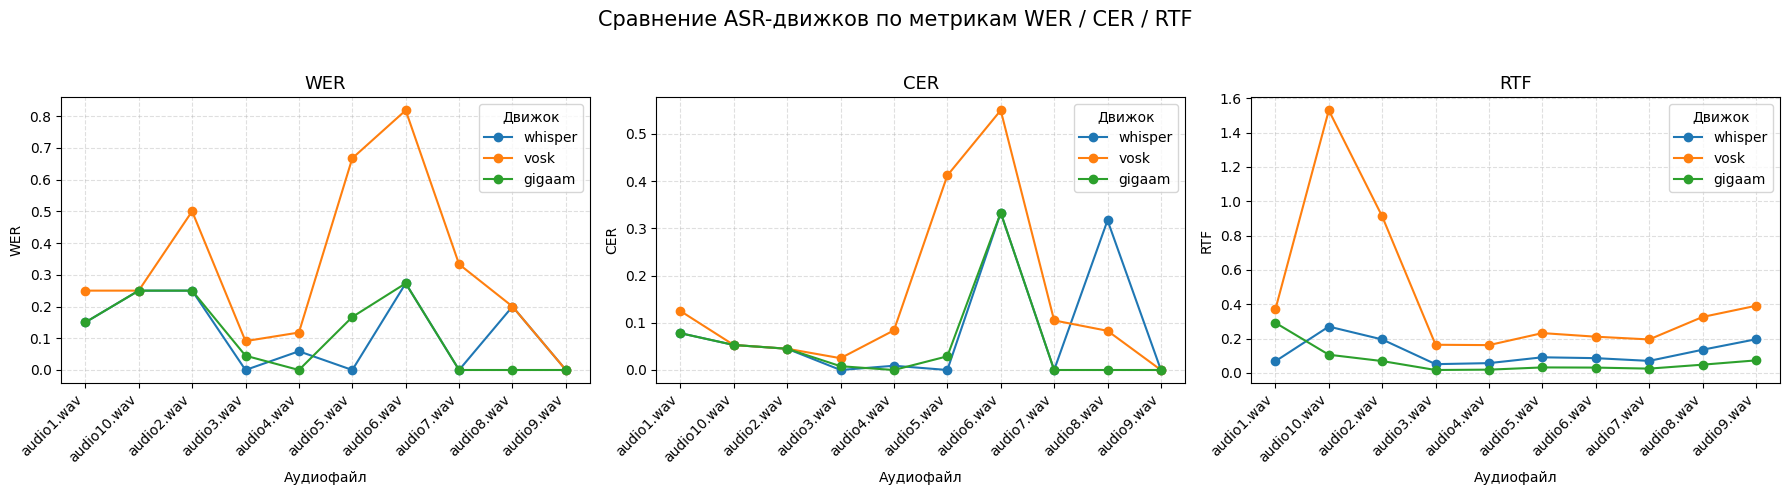

In [ ]:
import matplotlib.pyplot as plt

# === построение графиков ===
def plot_asr_comparison(df):
    metrics = ["WER", "CER", "RTF"]
    files = sorted(df["file"].unique())
    engines = df["engine"].unique()

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for i, metric in enumerate(metrics):
        ax = axes[i]
        for eng in engines:
            sub = df[df["engine"] == eng].sort_values("file")
            ax.plot(sub["file"], sub[metric], marker="o", label=eng)
        ax.set_title(metric, fontsize=13)
        ax.set_xlabel("Аудиофайл")
        ax.set_ylabel(metric)
        ax.legend(title="Движок")
        ax.grid(True, linestyle="--", alpha=0.4)
        ax.set_xticks(range(len(files)))
        ax.set_xticklabels(files, rotation=45, ha='right')

    plt.suptitle("Сравнение ASR-движков по метрикам WER / CER / RTF", fontsize=15)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# === вызываем функцию ===
plot_asr_comparison(df)


In [9]:
import os
import time
import json
import soundfile as sf
from faster_whisper import WhisperModel

# === Пути ===
BASE_DIR = "/content/drive/MyDrive/asr_lab/domain"
AUDIO_DIR = f"{BASE_DIR}/wavs"
OUT_DIR = f"{BASE_DIR}/results"
HYP_DIR = f"{OUT_DIR}/hypotheses"
META_DIR = f"{OUT_DIR}/metadata"

os.makedirs(HYP_DIR, exist_ok=True)
os.makedirs(META_DIR, exist_ok=True)

In [14]:

# === Модель ===
model = WhisperModel("small", device="cpu", compute_type="float32")

def transcribe_with_metrics(path, beam_size=5, initial_prompt=None):
    start = time.time()
    segments, info = model.transcribe(path, beam_size=beam_size, initial_prompt=initial_prompt)
    end = time.time()
    text = " ".join([s.text.strip() for s in segments]).strip()
    duration = sf.info(path).duration
    rtf = (end - start) / duration
    return text, info.language, info.language_probability, end - start, duration, rtf

# === Прогон без prompt ===
for name in sorted(os.listdir(AUDIO_DIR)):
    if not name.endswith(".wav"):
        continue
    path = os.path.join(AUDIO_DIR, name)
    text, lang, prob, proc_time, duration, rtf = transcribe_with_metrics(path)

    # === Сохраняем ===
    hyp_path = os.path.join(HYP_DIR, f"whisper_noprompt_{name.replace('.wav', '.txt')}")
    with open(hyp_path, "w", encoding="utf-8") as f:
        f.write(text)
    meta = {
        "file": name,
        "engine": "whisper_noprompt",
        "language": lang,
        "lang_prob": prob,
        "processing_time_s": proc_time,
        "audio_duration_s": duration,
        "rtf": rtf
    }
    with open(os.path.join(META_DIR, f"whisper_noprompt_{name.replace('.wav', '.json')}"), "w", encoding="utf-8") as f:
        json.dump(meta, f, indent=2, ensure_ascii=False)
    print(f"✅ {name} done — RTF={rtf:.3f}")


✅ audio1.wav done — RTF=2.234
✅ audio2.wav done — RTF=2.358
✅ audio3.wav done — RTF=1.959
✅ audio4.wav done — RTF=2.000
✅ audio5.wav done — RTF=2.140


In [15]:
domain_prompt = """
трансформер внимание токенизация гиперпараметры GPT API модель искусственный интеллект оптимизация нейронные сети
"""

for name in sorted(os.listdir(AUDIO_DIR)):
    if not name.endswith(".wav"):
        continue
    path = os.path.join(AUDIO_DIR, name)
    text, lang, prob, proc_time, duration, rtf = transcribe_with_metrics(path, initial_prompt=domain_prompt)

    # === Сохраняем ===
    hyp_path = os.path.join(HYP_DIR, f"whisper_prompt_{name.replace('.wav', '.txt')}")
    with open(hyp_path, "w", encoding="utf-8") as f:
        f.write(text)
    meta = {
        "file": name,
        "engine": "whisper_prompt",
        "language": lang,
        "lang_prob": prob,
        "processing_time_s": proc_time,
        "audio_duration_s": duration,
        "rtf": rtf
    }
    with open(os.path.join(META_DIR, f"whisper_prompt_{name.replace('.wav', '.json')}"), "w", encoding="utf-8") as f:
        json.dump(meta, f, indent=2, ensure_ascii=False)
    print(f"✅ {name} done — RTF={rtf:.3f}")


✅ audio1.wav done — RTF=2.087
✅ audio2.wav done — RTF=2.115
✅ audio3.wav done — RTF=2.099
✅ audio4.wav done — RTF=1.762
✅ audio5.wav done — RTF=3.497


In [16]:
import re
from jiwer import wer
import pandas as pd
import json

REF_DIR = f"{BASE_DIR}/refs"

def normalize(text):
    text = text.lower()
    text = re.sub(r"[^а-яa-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

def cer(ref, hyp):
    r, h = list(ref), list(hyp)
    D = [[0]*(len(h)+1) for _ in range(len(r)+1)]
    for i in range(len(r)+1): D[i][0] = i
    for j in range(len(h)+1): D[0][j] = j
    for i in range(1,len(r)+1):
        for j in range(1,len(h)+1):
            cost = 0 if r[i-1]==h[j-1] else 1
            D[i][j] = min(D[i-1][j]+1, D[i][j-1]+1, D[i-1][j-1]+cost)
    return D[-1][-1] / max(1,len(r))

results = []
for engine in ["whisper_noprompt", "whisper_prompt"]:
    for ref_file in sorted(os.listdir(REF_DIR)):
        if not ref_file.endswith(".txt"):
            continue
        fname = ref_file.replace(".txt", "")
        ref_path = os.path.join(REF_DIR, ref_file)
        hyp_path = os.path.join(HYP_DIR, f"{engine}_{ref_file}")
        meta_path = os.path.join(META_DIR, f"{engine}_{ref_file.replace('.txt','.json')}")
        if not os.path.exists(hyp_path):
            continue

        with open(ref_path, encoding='utf-8') as f: ref = normalize(f.read())
        with open(hyp_path, encoding='utf-8') as f: hyp = normalize(f.read())
        with open(meta_path, encoding='utf-8') as f: meta = json.load(f)

        results.append({
            "file": fname,
            "engine": engine,
            "WER": wer(ref, hyp),
            "CER": cer(ref, hyp),
            "RTF": meta.get("rtf", None)
        })

df = pd.DataFrame(results)
display(df)


,file,engine,WER,CER,RTF
0,audio1,whisper_noprompt,0.272727,0.060976,2.234232
1,audio2,whisper_noprompt,0.333333,0.102564,2.357594
2,audio3,whisper_noprompt,0.200000,0.095890,1.958761
3,audio4,whisper_noprompt,0.111111,0.025974,1.999743
4,audio5,whisper_noprompt,0.285714,0.072289,2.139779
5,audio1,whisper_prompt,0.272727,0.060976,2.086891
6,audio2,whisper_prompt,0.222222,0.076923,2.115197
7,audio3,whisper_prompt,0.200000,0.095890,2.099007
8,audio4,whisper_prompt,0.111111,0.025974,1.762059
9,audio5,whisper_prompt,0.428571,0.108434,3.497272


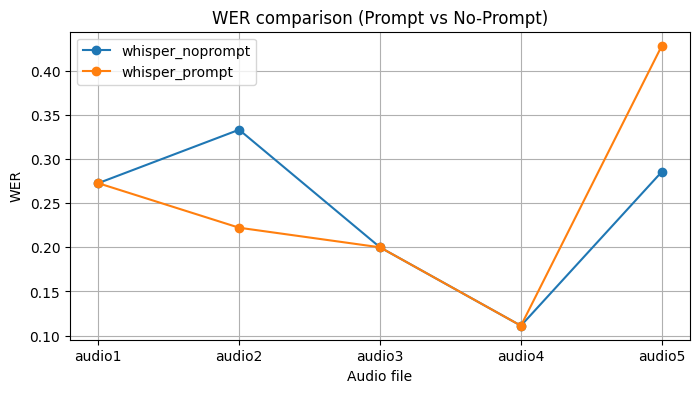

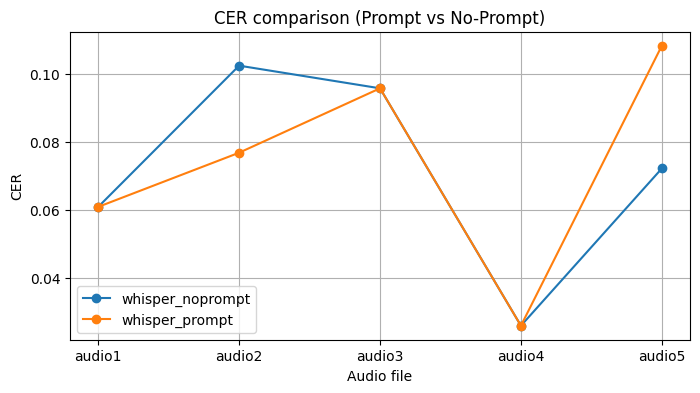

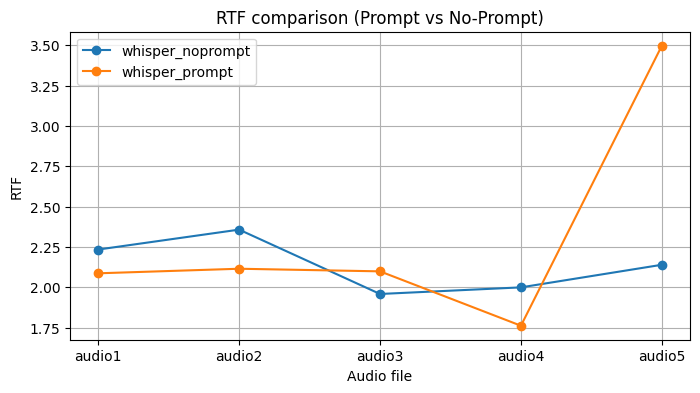

In [17]:
import matplotlib.pyplot as plt

metrics = ["WER", "CER", "RTF"]

for metric in metrics:
    plt.figure(figsize=(8,4))
    for engine in ["whisper_noprompt", "whisper_prompt"]:
        subset = df[df.engine == engine]
        plt.plot(subset["file"], subset[metric], marker="o", label=engine)
    plt.title(f"{metric} comparison (Prompt vs No-Prompt)")
    plt.xlabel("Audio file")
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.show()
